### This notebook serves as an example notebook that demonstrates the basic functionality of the `nimbus` package to generate posterior probabilities for kilonova models, by going through each of the steps outlined in the README of the package repository.

This packgage is based on [Mohite et al. (2021)](arxiv_link). Any comments/suggestions regarding the package can be directed to srmohite@uwm.edu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In order to begin the inference we need to initialize our data inputs. As shown in the README file for this package, we need the following data inputs to get started. We consider the event GW190425 as an example.

For the purposes of this example notebook we only consider follow-up data from 2 fields (`field=420` and `field=584`) to demonstrate the basic functionality of each script.

In [3]:
data_file = 'GW190425_data_file.csv'
samples_file = 'prior_samples.txt'
survey_file = 'ZTF_fields.pkl'
skymap_file = 'GW190425z-LALInference.fits.gz'
t_start = '2019-04-25T08:18:05' # Start time is the merger time of the event.
t_end = '2019-04-28T08:18:05' # We only consider 3 days of follow-up data here.

Let us load and print the data inputs here to get a sense for what the inference expects.

In [5]:
data = pd.read_csv(data_file)
prior_samples = np.loadtxt(samples_file)
survey_data = pd.read_pickle(survey_file)

In [6]:
data.head()

,jd,field,scimaglim,fid,status
0,2.458599e+06,584,21.28,2,1
1,2.458599e+06,584,21.43,2,1
2,2.458599e+06,584,21.40,2,1
3,2.458599e+06,584,21.48,2,1
4,2.458599e+06,584,21.31,2,1


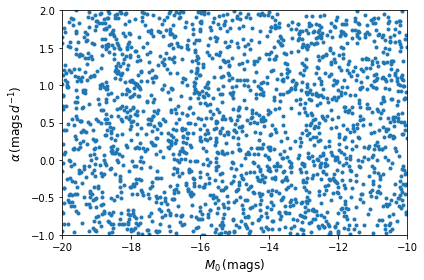

In [19]:
plt.plot(prior_samples[:,0],prior_samples[:,1],'.')
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()

In [9]:
survey_data.head()

,field_ID,RA,DEC,ipix,A_g,A_r,A_i,ebv
0,1,0,-89.05,"[785448, 785533, 785534, 785535, 785616, 78561...",0.481138,0.332849,0.247343,0.126026
1,2,90,-89.05,"[785470, 785554, 785555, 785556, 785636, 78563...",0.461328,0.319144,0.237159,0.120837
2,3,180,-89.05,"[785492, 785575, 785576, 785577, 785656, 78565...",0.40455,0.279866,0.20797,0.105965
3,4,270,-89.05,"[785426, 785512, 785513, 785514, 785596, 78559...",0.509038,0.35215,0.261685,0.133333
4,5,16.3636,-81.85,"[783487, 783637, 783638, 783639, 783785, 78378...",0.392867,0.271784,0.201965,0.102905


Once the data inputs are initialized, we follow the steps and code given outlined in the README to calculate, first, the field specific likelihood values and then combine the data from all the fields.

### Step 1 : Single field inference

The single field inference stage involves calculating the field specific likelihood under the assumption that the event is localized within the field. In general, a given event could have a large number of fields for which there exists follow-up data and this step would need to be implemented in parallel for all those fields. However, we only demonstrate this for 2 fields (as defined above) as an example and for computational ease.

We make use of the script `singlefield_calc`. By default this script assumes the inference is for multiple passband filters (3 in this case). The script also assumes that the kilonova luminosity (mags) evolution model is linear in time and is defined by only two parameters $M_{0}, \alpha$ which are the initial brightness and decay/rise slope respectively. Thus, the prior sample file above also contains prior draws corresponding to these two parameters.

    def lc_model_linear(M0, alpha, t_0, t):
        return M0 + alpha*(t-t_0)
        
If users need to change either of these aspects they would need to modify the script appropriately. Note : The script does have an option called `single_band` to model the luminosity evolution across a single (combined) passband filter.

The command-line implementation of this script, for `field=584` would be (as given in the README):

    singlefield_calc --field=584 --data_file=data_file --survey_file=survey_file --skymap_file=skymap_file --sample_file=samples_file --t_start=t_start --t_end=t_end --output_str=infield_likelihood_singleband_ --single_band
 
This will produce an output file named `infield_likelihood_singleband_584.txt` that contains likelihood values corresponding to each prior sample in the `sample_file`. 

In [20]:
likelihood_420 = np.loadtxt('infield_likelihood_singleband_420.txt')
likelihood_584 = np.loadtxt('infield_likelihood_singleband_584.txt')

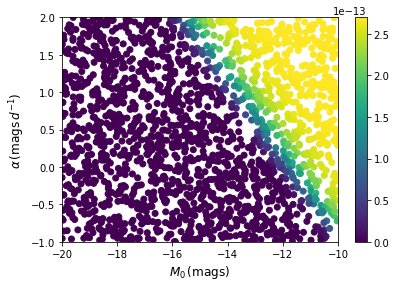

In [23]:
plt.scatter(prior_samples[:,0],prior_samples[:,1],c=likelihood_420)
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()
plt.colorbar()

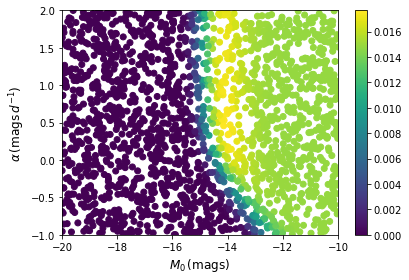

In [24]:
plt.scatter(prior_samples[:,0],prior_samples[:,1],c=likelihood_584)
plt.xlabel(r'$M_{0} \, (\mathrm{mags})$',fontsize=12)
plt.ylabel(r'$\alpha \, (\mathrm{mags} \, d^{-1})$',fontsize=12)
plt.xlim(-20,-10)
plt.ylim(-1,2)
plt.tight_layout()
plt.colorbar()

### Step 2 : Compute field probabilities

Once the likelihood values for all fields have been computed, we need to compute the probability that the event is in each field in order to combine the results from multiple fields. This is done with the help of the `compute_field_probs` script using the `survey_file`, `skymap_file` for the event and the likelihood files produced above. In this case the implementation would be:

    compute_field_probs --field_probs_file=field_probs.txt --survey_file=survey_file --skymap_file=skymap_file --infield_likelihoods_path=./infield_likelihood*.txt --common_str=infield_likelihood_singleband_
    
This will produce an output file named `field_probs.txt` that contains the event localization probabilities (stored in order) for every field that has a likelihood calculation associated with it.

### Step 3 : Combine field likelihoods

The final step in the inference is to combine the individual field likelihoods and field probabilites from Steps 1 and 2 to give us the log-likelihood values for each hyperparameter sample. This is done using the `combine_fields` executable.

    combine_fields --sample_file=samples_file --field_probs_file=field_probs.txt --infield_likelihoods_path=./infield_likelihood*.txt [--coverage_fraction COV_FRAC] --P_A 0.999 --output_file GW190425_samples_likelihood.txt